In [1]:
#Author-Vishal Burman

## Image Classification Data(Fashion-MNIST)

In [2]:
%matplotlib inline
from mxnet import gluon
import sys

In [3]:
import matplotlib.pyplot as plt

In [4]:
#Gluon provides fashion-mnist class to download and load this dataset

In [5]:
mnist_train=gluon.data.vision.FashionMNIST(train=True)
mnist_test=gluon.data.vision.FashionMNIST(train=False)

In [6]:
# The number of images in train_set and test_set is set to 6000 and 1000 for each category
# Since there are 10 categories...therefore there are in total 60000 and 10000

In [7]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [8]:
# Following function convert a numerical label into corresponding text label

In [9]:
def get_fashion_mnist_labels(labels):
    text_labels=['t-shirt', 'trouser', 'pullover', 'dress', 'coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int (i)] for i in labels]

In [10]:
#Visualising one of the images

In [11]:
X, y = mnist_train[10]
X=X.squeeze(axis=-1)

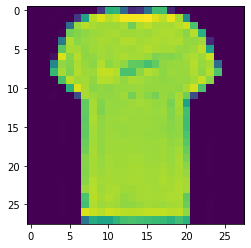

In [12]:
plt.imshow(X.asnumpy())

In [13]:
# Reading data can be a performance bottleneck when model is simple and computer is fast
# Gluon's dataloader uses multiple processes to speed up data processes
# Note the number of workers defined doesn't work in windows...currently i am in Windows :-)

In [14]:
def get_dataloader_workers(num_workers=4):
    if sys.platform.startswith("win"):
        return 0
    else:
        return num_workers

In [15]:
batch_size=256
transformer = gluon.data.vision.transforms.ToTensor()
train_iter=gluon.data.DataLoader(mnist_train.transform_first(transformer), batch_size, shuffle=True, num_workers=get_dataloader_workers())

In [16]:
# Let's look at the time to read the data

In [17]:
%%time
for X, y in train_iter:
    continue

Wall time: 12.6 s


## Putting all things together

In [20]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Load the fashion-mnist data into the memory"""
    dataset=gluon.data.vision
    trans=[dataset.transforms.Resize(resize)] if resize else []
    trans.append(dataset.transforms.ToTensor())
    trans=dataset.transforms.Compose(trans)
    mnist_train=dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_test=dataset.FashionMNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=get_dataloader_workers())), (gluon.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers()))

In [21]:
# Verify image resizing works

In [22]:
train_iter, test_iter=load_data_fashion_mnist(32, (64, 64))
for X, y in train_iter:
    print(X.shape)
    break

(32, 1, 64, 64)


## Implementation of Softmax Regression from Scratch

In [23]:
from mxnet import autograd, nd, gluon

In [24]:
batch_size=256
train_iter, test_iter=load_data_fashion_mnist(batch_size)

In [25]:
# Our dataset has 10 categories and our weights will constitute 784x10 matrix and biases will constitute 1x10 vector
# We initialize our weights from the Gaussian distribution

In [26]:
num_inputs=784
num_outputs=10

W=nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b=nd.zeros(num_outputs)

In [27]:
# Attaching gradients to model parameters

In [28]:
W.attach_grad()
b.attach_grad()

## The Softmax

In [29]:
# Axes:
# 0-> column
# 1-> row

In [32]:
X=nd.array([[1, 2, 3], [4, 5, 6]])
X.sum(axis=0, keepdims=True), X.sum(axis=1, keepdims=True)

(
 [[5. 7. 9.]]
 <NDArray 1x3 @cpu(0)>, 
 [[ 6.]
  [15.]]
 <NDArray 2x1 @cpu(0)>)

In [33]:
# Here we implemet the softmax function

In [35]:
# The implementation is sloppy...not taken precautions against numerical overflow or underflow

In [39]:
def softmax(X):
    X_exp=X.exp()
    partition=X_exp.sum(axis=1, keepdims=True)
    return X_exp/partition # The broadcast mechanism applies here

In [41]:
X=nd.random.normal(shape=(2, 5))
X_prob=softmax(X)
X_prob, X_prob.sum(axis=1)

(
 [[0.13066927 0.05587501 0.05137373 0.16906908 0.59301287]
  [0.16064428 0.16010803 0.45925817 0.10437898 0.11561053]]
 <NDArray 2x5 @cpu(0)>, 
 [1. 1.]
 <NDArray 2 @cpu(0)>)

## The model

In [42]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

## The Loss Function

In [43]:
# The pick function allows to select the appropriate terms from the matrix of softmax entries easily

In [45]:
y_hat=nd.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y=nd.array([0, 2], dtype='int32')
nd.pick(y_hat, y)


[0.1 0.5]
<NDArray 2 @cpu(0)>

In [46]:
# We can implement the cross-entropy loss function with just one line of code

In [47]:
def cross_entropy(y_hat, y):
    return -nd.pick(y_hat, y).log()

## Classification Accuracy

In [48]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1)==y.astype('float32')).sum().asscalar()

In [49]:
# We can evaluate the accuracy for model net on the data set(accessed via data_iter)

In [50]:
def evaluate_accuracy(net, data_iter):
    metric=Accumulator(2)
    for X, y in data_iter:
        y=y.astype('float32')
        metric.add(accuracy(net(X), y), y.size)
    return metric[0]/metric[1]

In [51]:
# Accumulator is a utility class to accumulate sum over multiple numbers

In [52]:
class Accumulator(object):
    """Sum a list of numbers over time"""
    
    def __init__(self, n):
        self.data=[0.0]*n
    
    def add(self, *args):
        self.data=[a+b for a,b in zip(self.data, args)]
        
    def reset(self):
        self.data=[0]*len(self.data)
    
    def __getitem__(self, i):
        return self.data[i]

In [ ]:
# The model's accuracy should be close to random guessing

In [53]:
evaluate_accuracy(net, test_iter)

0.0856

## Model Training

In [54]:
def train_epoch(net, train_iter, loss, updater):
    metric=Accumulator(3) #Train_loss_sum, train_acc_sum, num_examples
    if isinstance(updater, gluon.Trainer):
        updater=updater.step
    for X, y in train_iter:
        #Compute gradients and update paramaters
        with autograd.record():
            y_hat=net(X)
            l=loss(y_hat, y)
        l.backward()
        updater(X.shape[0])
        metric.add(l.sum().asscalar(), accuracy(y_hat, y), y.size)
    # Return training_loss and training_accuracy
    return metric[0]/metric[2], metric[1]/metric[2]

In [55]:
def train(net, train_iter, test_iter, loss, num_epochs, updater ):
    trains, test_acc=[], []
    for epoch in range(num_epochs):
        train_metrics=train_epoch(net, train_iter, loss, updater)
        test_acc=evaluate_accuracy(net, test_iter)
        print(train_metrics, test_acc)